# __A/B TESTING For Website Design__
---

### Content
1. [About A/B test](#About)
1. [Loading and Processing Data](#Loading)
2. [Statistical Analysis](#Statistical)
3. [Discussion](#Discussion)

### About A/B test <a name='About' />
At its core, __A/B testing__ involves comparing two populations (__Group A__ and __Group B__ – hence __A/B__) to assess their performance regarding a specific variable of interest (the __response variable__).

differences between A/B Testing and traditional hypothesis testing:

|                   | Traditional Hypothesis Testing | A/B Test   |
|-------------------|--------------------------------|------------|
| Sample size       | Fixed – determined before the experiment begins and remains unchanged.                     | Flexible – data is monitored as they come. |
| Testing Framework | Static – set in advance, including the significance level and decision rules.                     | Dynamic – decisions are made as the experiment goes for a more iterative process. |




### Loading and Preprocessing Data <a name='Loading' />

Import the necessary libraries

In [1]:
import numpy as np            # calculation
import pandas as pd             # dataframe
import matplotlib.pyplot as plt                # plot
import seaborn as sns             # quickly create plots

from scipy.stats import shapiro     # check dist.'s nomrality
from scipy.stats import mannwhitneyu     # for Mann Whitney U test

Load data and take a quick look at the data

In [2]:
df = pd.read_csv('data/results1.csv')
df.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


In [3]:
# distribution of the data
print(df.describe())
# number of missing values in each column
df.isnull().sum()

            USER_ID       REVENUE
count  10000.000000  10000.000000
mean    4981.080200      0.099447
std     2890.590115      2.318529
min        2.000000      0.000000
25%     2468.750000      0.000000
50%     4962.000000      0.000000
75%     7511.500000      0.000000
max    10000.000000    196.010000


USER_ID         0
VARIANT_NAME    0
REVENUE         0
dtype: int64

Check the independence of the two groups 

In [4]:
# number of distinct elements in 'USER_ID' column
print(df['USER_ID'].nunique())
# are the two groups independent from each other?
df['USER_ID'].nunique() == len(df)

6324


False

In [5]:
# testing number of each user
print(df.groupby("USER_ID")["VARIANT_NAME"].nunique())
# relative numbers of each testing number
testing_num = df.groupby('USER_ID')['VARIANT_NAME'].nunique().value_counts()
testing_num/testing_num.sum()

USER_ID
2        1
3        2
4        1
5        1
6        1
        ..
9993     1
9995     1
9996     2
9998     1
10000    2
Name: VARIANT_NAME, Length: 6324, dtype: int64


VARIANT_NAME
1    0.756325
2    0.243675
Name: count, dtype: float64

We see there are a lot of users were tested twice with two web designs - 24%, which means the observations from them are not independent. Taking these users into account will blur the effect of changes in the experiment. Therefore, we exclude these user data for analysis

In [6]:
# filter out users having one ab test group
users_single = df.groupby('USER_ID')['VARIANT_NAME'].nunique() == 1
users_single = users_single[users_single]
print(users_single)
df = df[df['USER_ID'].isin(users_single.index)]
df

USER_ID
2       True
4       True
5       True
6       True
9       True
        ... 
9990    True
9992    True
9993    True
9995    True
9998    True
Name: VARIANT_NAME, Length: 4783, dtype: bool


,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
4,6174,variant,0.0
5,2380,variant,0.0
7,9168,control,0.0
9,7548,control,0.0
...,...,...,...
9993,2400,variant,0.0
9994,3129,control,0.0
9996,502,variant,0.0
9998,7741,control,0.0


In [7]:
# just in case, check that the number of users in the df now matches the number of users with one variant (before the exception)
df.groupby('USER_ID')['VARIANT_NAME'].nunique().value_counts()
df.groupby('USER_ID')['VARIANT_NAME'].nunique().value_counts().iloc[0] 
df.groupby('USER_ID')['VARIANT_NAME'].nunique().value_counts().iloc[0] == testing_num.iloc[0]

True

See how the data is distributed

<Axes: xlabel='VARIANT_NAME', ylabel='REVENUE'>

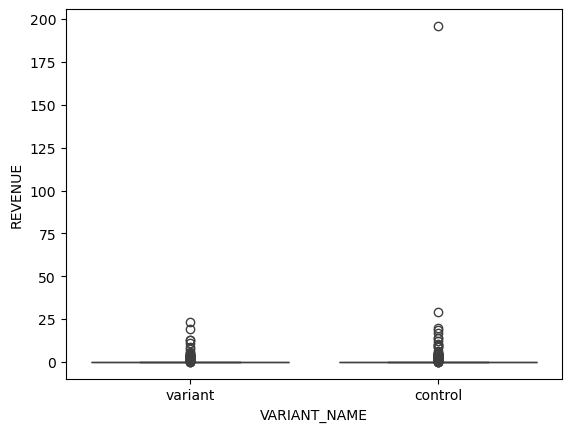

In [8]:
sns.boxplot(x='VARIANT_NAME', y='REVENUE', data=df)

It can be seen that there is a strong outlier in the data. Let's sort these revenue values in descending order to find it

In [9]:
# see the first five rows of the df
df.sort_values(by='REVENUE', ascending=False).iloc[:5]

,USER_ID,VARIANT_NAME,REVENUE
1437,3342,control,196.01
8168,2166,control,29.32
2482,7356,variant,23.04
6412,1053,control,20.07
5217,3684,variant,19.47


Let's see if user 3342 had other events with a strong outlier

In [10]:
df[df['USER_ID'] == 3342]

,USER_ID,VARIANT_NAME,REVENUE
1437,3342,control,196.01


We see that there is only one outlier and in conditions of limited information, we will remove this entry and look at the distribution of data again

In [11]:
# delete that entry from the df
df = df[df['USER_ID'] != 3342]

<Axes: xlabel='VARIANT_NAME', ylabel='REVENUE'>

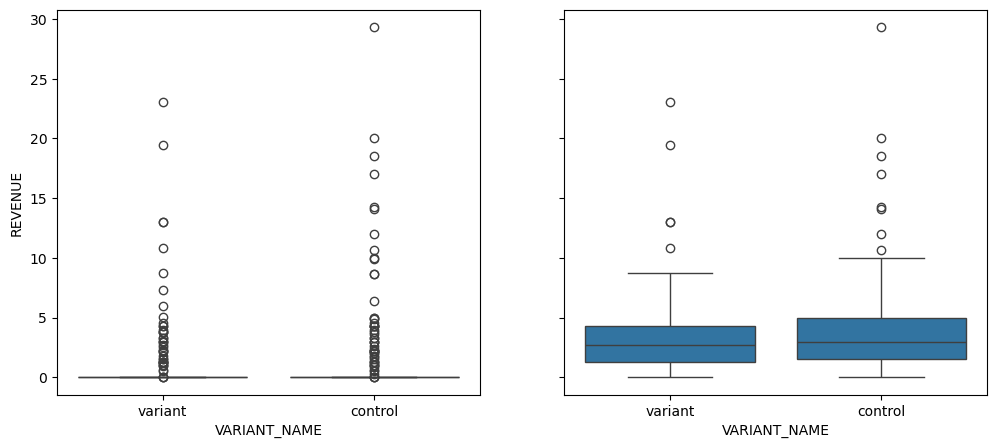

In [12]:
f, axes = plt.subplots(1,2, sharey=True, sharex=True, figsize=(12,5))
sns.boxplot(ax = axes[0], x = 'VARIANT_NAME', y = 'REVENUE', data = df)
# filter out RENVENUE values which = 0 to see the box distribution
sns.boxplot(ax = axes[1], x = 'VARIANT_NAME', y = 'REVENUE', data = df[df['REVENUE'] > 0])

We see that most of the users have no purchases. Now we need to check if these records are including users' multiple visits, that some times they have zero purchases while some have positive purchases.

In [13]:
# count the number of users who have records with both zero and positive

# df.loc[df['REVENUE'] > 0]   # select the users with positive revenue in format of df
# df.loc[df['REVENUE'] > 0, 'USER_ID']   # leave the indexes in the original df & user id
# df.loc[df['REVENUE'] > 0, 'USER_ID'].values    # leave the user ids (in form of an array)
# df['USER_ID'].isin(df.loc[df['REVENUE'] > 0, 'USER_ID'].values)    # a series of boolean values that if each user id in the original df 
#                                                                     # is in the positive-revenue array
# df.loc[
#     (df['REVENUE'] == 0) & (df['USER_ID'].isin(df.loc[df['REVENUE'] > 0, 'USER_ID'].values)), 
#     'USER_ID'
# ]    # leave all user ids whose records are both zero and positive
(df.loc[
    (df['REVENUE'] == 0) & (df['USER_ID'].isin(df.loc[df['REVENUE'] > 0, 'USER_ID'].values)), 
    'USER_ID'
]).count()

52

The same user can indeed have records with both zero and positive revenue.

Let's summarize those records to get the sum REVENUE for each user id

In [14]:
df = df.groupby(by=['USER_ID', 'VARIANT_NAME']).sum().reset_index()
# check the summarization result
(df.loc[
    (df['REVENUE'] == 0) & (df['USER_ID'].isin(df.loc[df['REVENUE'] > 0, 'USER_ID'].values)), 
    'USER_ID'
]).count()      # => 0

0

Let's look at the resulting distributions

<Axes: xlabel='VARIANT_NAME', ylabel='REVENUE'>

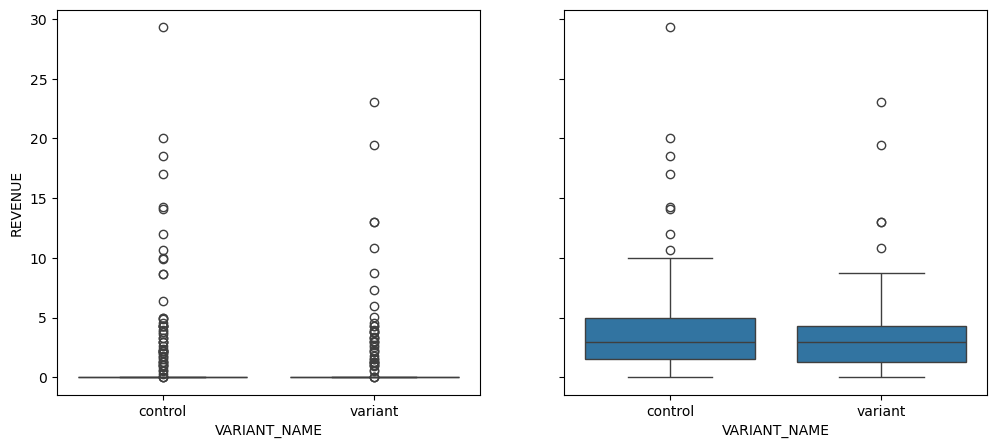

In [15]:
f, axes = plt.subplots(1,2, sharex=True, sharey=True, figsize=(12,5))
sns.boxplot(ax = axes[0], x = 'VARIANT_NAME', y = 'REVENUE', data = df)
sns.boxplot(ax = axes[1], x = 'VARIANT_NAME', y = 'REVENUE', data = df[df['REVENUE'] > 0])

It should be noted that during the transformation, the quantiles in the test group increased

It can be seen that in the test group, almost all quantile statistics, except for the minimum, are at a slightly lower level.

Let's look at various statistics in the context of AB test groups for all users

In [16]:
# get metrics by groups
all_stat = df.groupby(by='VARIANT_NAME').agg({'USER_ID': 'nunique',
                                            'REVENUE': ['sum', 'mean', 'median', 'count']})

# create two additional metrics to see relative changes
orders_per_user = all_stat.loc[:, ('REVENUE', 'count')] / all_stat.loc[:, ('USER_ID', 'nunique')]
revenue_per_user = all_stat.loc[:, ('REVENUE', 'sum')] / all_stat.loc[:, ('USER_ID', 'nunique')]

# add them to the rest of the metrics in a separate group
all_stat.loc[:, ('per_user', 'orders')] = orders_per_user
all_stat.loc[:, ('per_user', 'revenue')] = revenue_per_user

all_stat

USER_ID REVENUE                        per_user          
             nunique     sum      mean median count   orders   revenue
VARIANT_NAME                                                          
control         2389  274.55  0.114923    0.0  2389      1.0  0.114923
variant         2393  179.32  0.074935    0.0  2393      1.0  0.074935

We see that in the test (variant) group, the total amount of revenue of the users and the average revenue per user decreased, but the number of users are slightly more.

Let's also see how paying users behave

In [17]:
paid_stat = df.loc[df.REVENUE!= 0].groupby(by='VARIANT_NAME').agg({'USER_ID': 'nunique',
                                            'REVENUE': ['sum', 'mean', 'median', 'count']})

# add two additional metrics to see relative changes
orders_per_user = paid_stat.loc[:, ('REVENUE', 'count')] / paid_stat.loc[:, ('USER_ID', 'nunique')]
revenue_per_user = paid_stat.loc[:, ('REVENUE', 'sum')] / paid_stat.loc[:, ('USER_ID', 'nunique')]
paid_stat.loc[:, ('per_user', 'orders')] = orders_per_user
paid_stat.loc[:, ('per_user', 'revenue')] = revenue_per_user

paid_stat

USER_ID REVENUE                        per_user          
             nunique     sum      mean median count   orders   revenue
VARIANT_NAME                                                          
control           53  274.55  5.180189   2.99    53      1.0  5.180189
variant           42  179.32  4.269524   2.97    42      1.0  4.269524

Let's look at the distributions of all and only paying users

C:\Users\sunxi\AppData\Local\Temp\ipykernel_43692\268597570.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.loc[df.VARIANT_NAME == 'control', 'REVENUE'], ax = axes[0], label='control')
C:\Users\sunxi\AppData\Local\Temp\ipykernel_43692\268597570.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.d

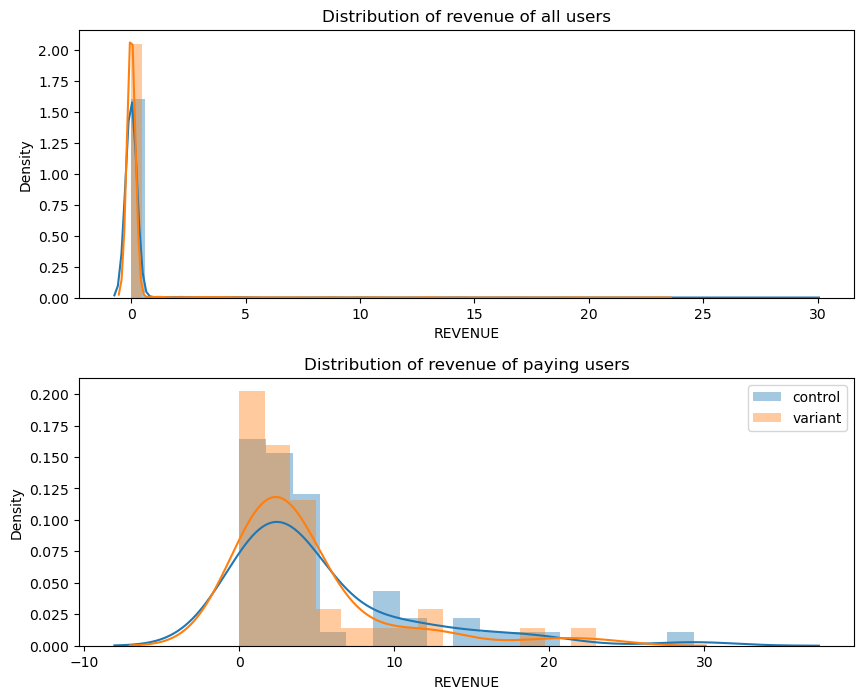

In [18]:
f, axes = plt.subplots(2, figsize=(10,8))

# build graphs of distributions of all users
sns.distplot(df.loc[df.VARIANT_NAME == 'control', 'REVENUE'], ax = axes[0], label='control')
sns.distplot(df.loc[df.VARIANT_NAME == 'variant', 'REVENUE'], ax = axes[0], label='variant')
axes[0].set_title('Distribution of revenue of all users')

# build graphs of distributions of paying users
sns.distplot(df.loc[(df.VARIANT_NAME == 'control') & (df.REVENUE > 0), 'REVENUE'], ax = axes[1], label='control')
sns.distplot(df.loc[(df.VARIANT_NAME == 'variant') & (df.REVENUE > 0), 'REVENUE'], ax = axes[1], label='variant')
axes[1].set_title('Distribution of revenue of paying users')

plt.legend() # 添加图例
plt.subplots_adjust(hspace = 0.3)  # eliminate the overlap between subplots

### Statistical Analysis <a name='Statistical' />

__A/B Testing__:
* Check normality (by applying Shapiro-Wilk Test)
* If Normal Distribution, check homogeneity:
    1. If parametric apply Levene Test for homogeneity of variances
    2. If Parametric + homogeneity of variances apply T-Test
    3. If Parametric - homogeneity of variances apply Welch Test
* If not Normal Distribution: Non-parametric apply Mann Whitney U Test directly


##### Shapiro-Wilk test

Based on the previous graph, we see that the data is not normally distributed, but just in case, we can confirm this formally using the Shapiro-Wilk criterion

In [19]:
# Shapiro-Wilk test(to determine whether a sample of data comes from a normal distribution), based on:
# H0:  The sample data comes from a normal distribution.
# H1: -- does not --
shapiro(df.loc[df.VARIANT_NAME == 'variant', 'REVENUE'])

ShapiroResult(statistic=0.06145986897942335, pvalue=9.962810723092505e-76)

The null hypothesis about the normal distribution of the data is rejected with p-value of 0.00.

##### Mann-Whitney test

We can see the data are similar in shape across the two groups from the plots above.
<!-- Some sources have a limitation of applicability in case of duplicate data -->
However, there are a lot of repetitions in our sample, and especially a lot of zero values, so in this case we need to be careful about this criterion.

In [20]:
# number of repetitive 0 in the data
(df.REVENUE == 0).sum()

4687

Let's first check on the data of all users

In [21]:
# Mann-Whitney U test is the non-parametric alternative test to the independent sample t-test. 
mannwhitneyu(df.loc[df.VARIANT_NAME == 'variant', 'REVENUE'], df.loc[df.VARIANT_NAME == 'control', 'REVENUE'])

MannwhitneyuResult(statistic=2845109.0, pvalue=0.24799555106821947)

And of only those who pay

In [22]:
mannwhitneyu(df.loc[(df.VARIANT_NAME == 'variant') & (df.REVENUE > 0), 'REVENUE'], 
             df.loc[(df.VARIANT_NAME == 'control') & (df.REVENUE > 0), 'REVENUE'])

MannwhitneyuResult(statistic=1029.0, pvalue=0.5314192217084708)

From the results above, we cannot reject the null hypothesis that the two populations are equal with either 0.248 p-value for all user data or 0.531 p-value for paying user data.

##### Bootstrap

In order to get more complete information about the differences between the median values (as a non-parametric statistical test) of the ab test groups, we will use bootstrap.

Let's create a function to get bootstrap samples and get a confidence interval, and then look at the sample statistics

In [23]:
# get bootstrapping data in Python

# to ensure reproducibility in A/B testing, set seed
np.random.seed(666)

def get_bootstrap_samples(data, reps):
# data = df.loc[df.VARIANT_NAME == 'control', 'REVENUE'].values
    indices = np.random.randint(0, len(data), (reps, len(data)))
    # indices = np.random.randint(0, 2389, (reps, 2389))
    samples = data[indices]
    return samples

In [24]:
# define a function to get confidence intervals
def get_ci(stat, alpha):
    boundaries = np.percentile(stat,[100*alpha/2.,100*(1-alpha/2.)])
    return boundaries

Now generate bootstrap samples for all users

In [25]:
control = get_bootstrap_samples(df.loc[df.VARIANT_NAME == 'control', 'REVENUE'].values, 10000)
variant = get_bootstrap_samples(df.loc[df.VARIANT_NAME == 'variant', 'REVENUE'].values, 10000)
# sns.kdeplot(np.mean(variant, axis=1), fill=True, label='variant')

And only for the paying users

In [26]:
control_paid = get_bootstrap_samples(df.loc[(df.VARIANT_NAME == 'control') & (df.REVENUE > 0), 'REVENUE'].values, 10000)
variant_paid = get_bootstrap_samples(df.loc[(df.VARIANT_NAME == 'variant') & (df.REVENUE > 0), 'REVENUE'].values, 10000)

Let's look at the distribution of means in the ab test groups

C:\Users\sunxi\AppData\Local\Temp\ipykernel_43692\1071882165.py:3: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(np.median(control, axis=1), fill=True, label='control')
C:\Users\sunxi\AppData\Local\Temp\ipykernel_43692\1071882165.py:4: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(np.median(variant, axis=1), fill=True, label='variant')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'Sample median distribution for all users')

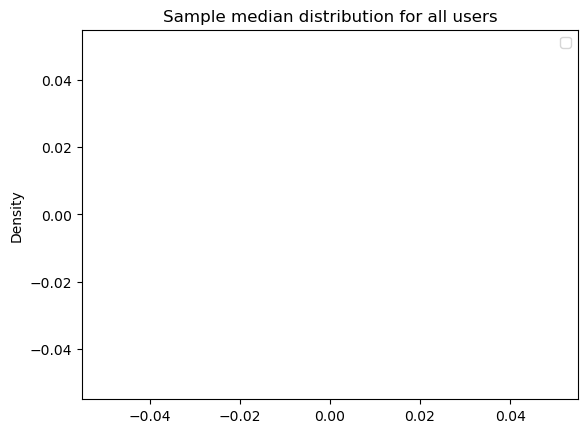

In [27]:
# all users
f, ax = plt.subplots()
sns.kdeplot(np.median(control, axis=1), fill=True, label='control')
sns.kdeplot(np.median(variant, axis=1), fill=True, label='variant')
plt.legend()
plt.title('Sample median distribution for all users')

There are too many 0 in sample medians for all users, let's just look at the distribution for paying users

Text(0.5, 1.0, 'Sample median distribution for paying users')

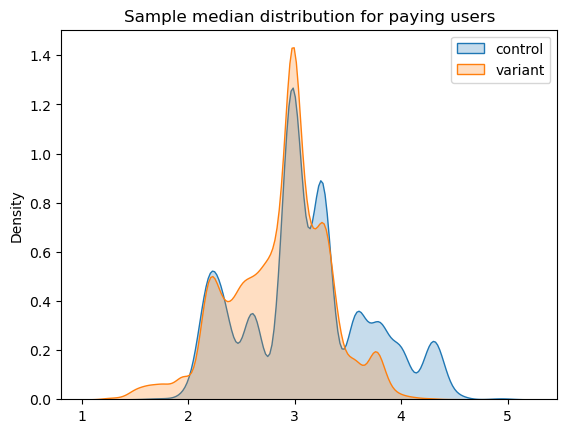

In [28]:
# paying user
f, ax = plt.subplots()
# plt.figure(figsize=(20,5))
sns.kdeplot(np.median(control_paid, axis=1), fill=True, label='control')
sns.kdeplot(np.median(variant_paid, axis=1), fill=True, label='variant')
plt.legend()
plt.title('Sample median distribution for paying users')

We see that there are differences, but the confidence intervals looks overlap a lot. Besides, we see the distribution of variant group even places on the left side of the distribution of control group, which indicates the median revenues of variant group may be even less than those of control group.

In [29]:
control_paid_ci = get_ci(np.median(control_paid, axis=1), 0.05)
variant_paid_ci = get_ci(np.median(variant_paid, axis=1), 0.05)
paid_ci_diff = get_ci((np.median(variant_paid, axis=1)-np.median(control_paid, axis=1)), 0.05)
print(control_paid_ci)
print(variant_paid_ci)
print(paid_ci_diff)

[2.17 4.33]
[1.839625 3.75    ]
[-1.77  1.08]


In [30]:
# # usually used for getting ci
# from scipy.stats import bootstrap


In [31]:
# control = df.loc[df.VARIANT_NAME == 'control', 'REVENUE'].values
# control = (control,)
# control = bootstrap(control, np.mean, confidence_level=0.9,
#                 random_state=np.random.default_rng())
# control

In [32]:
# variant = df.loc[df.VARIANT_NAME == 'variant', 'REVENUE'].values
# variant = (variant,)
# variant = bootstrap(variant, np.mean, confidence_level=0.9,
#                 random_state=np.random.default_rng())
# variant

### Discussion
In order to draw conclusions about changes between ab test groups, the following changes were first made to the data:

Users with two ab test groups were excluded in order to make the effect of the changes more pronounced.
User_id=3342 was excluded, because in conditions of limited information it is a strong outlier in the received sample
Users are taken as the experimental unit, and then the data is grouped by each user and revenue and summed over each to get one record per user.
Despite the fact that the revenue in the test group decreased significantly, there were no statistically significant changes between the ab test groups, both among all users and among only the paying audience. For a deeper analysis, the data of the A / A test and further study of the power of the criteria will be useful.

### Reference

1. Sergei L(2022). A/B test data. https://www.kaggle.com/datasets/sergylog/ab-test-data
2. Sergei L(2022). AB Test Data Analysis. https://www.kaggle.com/code/sergylog/ab-test-data-analysis/notebook
3. Serdar O(2023). A/B Testing 🧪 https://www.kaggle.com/code/serdarsozturk/a-b-testing/notebook